# UC3M-MLBD (GitHub Repo Name)

**Authors**: João M. Carvalho (100521356), George Y. Fang (100521298)

Repo for UC3M's ML for Business Decision Making course

**NIA number**: 56

## Project 1: Predicting Solar Energy Production with scikit-learn

### Introduction
This assignment focuses on practicing machine learning methods and hyper-parameter tuning to determine the optimal model for a given dataset. Participants will engage in model selection, evaluation, and making predictions on unseen data.

The context of this assignment is the challenge of forecasting energy production from renewable sources, specifically wind and solar energy. Unlike traditional sources, the generation of solar and wind energy depends on weather conditions and must be accurately predicted 24 hours in advance to ensure a balanced electricity network. Accurate weather forecasting models, like GFS and ECMWF, play a crucial role in predicting variables related to these renewable energies.

We will use meteorological data forecasted by GFS to train a machine learning model that estimates solar energy production at a solar plant in Oklahoma. The available dataset contains 15 meteorological variables, each forecasted at 5 different times of the day and at 4 locations around the solar plant, leading to 300 input attributes in total. The dataset spans from 1994-2007, and the model’s performance will be evaluated using competition data from 2008-2009. The objective is to accurately predict the energy produced, with the last column of the dataset indicating the response variable, i.e., the energy production.

### Deliverables
* EDA
* Two Simple models (KNN and DecisionTreeRegressor) and training and evaluation process description
* At Least Two Advanced models (SVM, RandomForest, GradientBoosting) and training and evaluation process description
* One Final Model (Using Joblib) and training and evaluation process description
* One .csv file with final predictions

# Outline: **to be deleted**

* Importing the data (Joao)
* EDA 
  * histogram (Joao)
  * looking for categorical data (George)
  * dropping columns (George)
* Standardize/scaling (Joao)
* Model 1: KNN (Joao)
* Model 2: Decision Tree (George)
* Model 3: SVM (George)
* Model 4: Random Forest (Joao)
* Extra Model: Gradient Boosting (Joao)
* Comparing all models
* Final Model selection and export.


# Part 0: Importing the data

We start by importing the data with our NIA number which is 56. In order to do this, we need to import the libraries we will use.

In [1]:
import pandas as pd
import numpy as np

Now we can read the provided .pkl file with pandas and create a dataframe with the data. We will also look at df.head to make sure that everything was imported correctly.

In [6]:
ava = pd.read_pickle('data/ava_st1_ns4_56.pkl')
ava.head

<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

For George's changes

After that initial cleanup, we can start looking at some visual representations of the data which will help us understand it better. We will start by looking at the histogram of the data to understand the distribution of energy values.

In [7]:
# First import the libraries we need
import matplotlib.pyplot as plt

# Now separate the data into X and y.
X = ava.drop('energy', axis=1)
y = ava['energy']

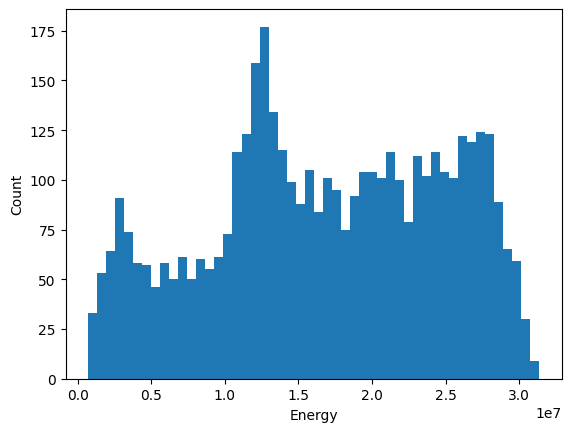

In [12]:
# To actually plot the histogram, we use matplotlib.pyplot.hist()
plt.hist(y, bins=50)
plt.xlabel('Energy')
plt.ylabel('Count')
plt.show()

As we can see in the histogram, our data appears to bi-modal. This will impact which evaluation model we use because we will need to make sure that error measurements are not skewed by the bi-modal distribution. 

Even though the distribution appears not to have any outliers, we will use the IQR method to detect and confirm this.

In [14]:
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (1.5*iqr)

# Identify the number of outliers

print('number of outliers: ', len(y[y > upper_bound]) + len(y[y < lower_bound]))

number of outliers:  0


With no outliers detected, we can proceed with the creation of our models. 

## 1st Model: KNN 

Our 1st model is a K Nearest Neighbors model. This model is a non-parametric method used for classification and regression. It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space. When an unknown discrete data is received, it analyzes the closest k number of instances saved (nearest neighbors) and returns the most common class as the prediction and for real-valued data, it returns the mean of k nearest neighbors.

